# Outlier detection experiments
---

Testing outlier detection algorithms on solar and metereologival time series data from the [University of Oregon](http://solardata.uoregon.edu/SelectArchival.html).

* Structure of data: http://solardata.uoregon.edu/ArchivalFiles.html
* Column codes: http://solardata.uoregon.edu/DataElementNumbers.html
* Quality control flags: http://solardata.uoregon.edu/QualityControlFlags.html
* Tested outlier detection algorithms: https://www.notion.so/andrecnf/Outlier-detection-06ba3f49b8114cc2a5a5bc6336c913ab

## Importing the necessary packages

In [1]:
import dask.dataframe as dd                # Dask to handle big data in dataframes
import pandas as pd                        # Pandas to load the data initially
from dask.distributed import Client        # Dask scheduler
import plotly                              # Plotly for interactive and pretty plots
import plotly.graph_objs as go
import os                                  # os handles directory/workspace changes
import numpy as np                         # NumPy to handle numeric and NaN operations
from tqdm import tqdm_notebook             # tqdm allows to track code execution progress
import glob                                # Read multiple files
import datetime                            # Filter dates and times

**Important:** Use the following two lines to be able to do plotly plots offline:

In [2]:
import plotly.offline as py
plotly.offline.init_notebook_mode(connected=True)

Allow pandas to show more columns:

In [3]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [4]:
# Change to parent directory
os.chdir("..")
import utils                               # Contains auxiliary functions

Set the random seed for reproducibility:

In [5]:
utils.set_random_seed(0)

Import the remaining custom packages:

In [6]:
import search_explore                      # Methods to search and explore data
import data_processing                     # Data processing and dataframe operations
# import embedding                           # Embedding and encoding related methods
# import padding                             # Padding and variable sequence length related methods
# import machine_learning                    # Common and generic machine learning related methods
# import deep_learning                       # Common and generic deep learning related methods

In [7]:
# Debugging packages
import pixiedust                           # Debugging in Jupyter Notebook cells

Pixiedust database opened successfully


In [8]:
# Change to parent directory (presumably "Documents")
os.chdir("../../..")

# Path to the CSV dataset files
data_path = 'Documents/Datasets/Outlier_Detection/UniversityOfOregon_SolarAndMeteorologicalData_Eugene/'
project_path = 'Documents/GitHub/eICU-mortality-prediction/'

In [9]:
# Set up local cluster
client = Client('tcp://127.0.0.1:61980')
client

<Client: scheduler='tcp://127.0.0.1:61980' processes=4 cores=8>

In [10]:
# Upload the utils.py file, so that the Dask cluster has access to relevant auxiliary functions
client.upload_file(f'{project_path}NeuralNetwork.py')
client.upload_file(f'{project_path}utils.py')
client.upload_file(f'{project_path}search_explore.py')
client.upload_file(f'{project_path}data_processing.py')

**Problem:** Somehow, all works fine if I initialize the Dask client without specifying the tcp address. But if I specify the one obtained from the Jupyter Lab Dask extension, it returns "ModuleNotFoundError: No module named 'torch'"! Perhaps the Jupyter Lab Dask extension is associated to a different Python environment.

**Solution:** Jupyter Lab must be started from within the desired virtual environment's shell.

In [11]:
client.run(os.getcwd)

{'tcp://127.0.0.1:61986': '/Users/andreferreira',
 'tcp://127.0.0.1:61987': '/Users/andreferreira',
 'tcp://127.0.0.1:61988': '/Users/andreferreira',
 'tcp://127.0.0.1:61989': '/Users/andreferreira'}

## Loading data

In [12]:
all_files = glob.glob(f'{data_path}/*.txt')

In [13]:
files_list = []

for filename in all_files:
    df = dd.read_csv(filename, header=0, sep='\t')
    files_list.append(df)

uoreg_df = dd.concat(files_list)

In [14]:
uoreg_df.head()

94255  2019  1000   0  2010  0.1  2011  0.2  1002  0.3  1003  0.4  1004  \
0    121     1     0  12     0   12     0   12     0   12     0   12     0   
1    121     2     0  12     0   12     0   12     0   12     0   12     0   
2    121     3     0  12     0   12     0   12     0   12     0   12     0   
3    121     4     0  12     0   12     0   12     0   12     0   12     0   
4    121     5     0  12     0   12     0   12     0   12     0   12     0   

   0.5  1007  0.6  1008  0.7  1009  0.8  2012  0.9  1090  0.10  1360  0.11  \
0   12     0   12     0   12     0   12     0   12     0    12     0    12   
1   12     0   12     0   12     0   12     0   12     0    12     0    12   
2   12     0   12     0   12     0   12     0   12     0    12     0    12   
3   12     0   12     0   12     0   12     0   12     0    12     0    12   
4   12     0   12     0   12     0   12     0   12     0    12     0    12   

   1960  0.12  1920  0.13  3002  0.14  3005  0.15  7003  0.16    9170  0.17  \
0     0    12     0    12     0    12     0    12   0.0    12  999.44    11   
1     0    12     0    12     0    12     0    12   0.0    12  999.44    11   
2     0    12     0    12     0    12     0    12   0.0    12  999.44    11   
3     0    12     0    12     0    12     0    12   0.0    12  999.43    11   
4     0    12     0    12     0    12     0    12   0.0    12  999.43    11   

   9200  0.18  9210  0.19  9300  0.20  9303  0.21  9330  0.22   9386  0.23  \
0  89.0    11   0.7    12   8.4    11   8.1    11  60.3    12  280.9    11   
1  83.2    11   0.7    12   8.4    11   8.1    11  60.3    12  280.9    11   
2  87.3    11   0.3    12   8.4    11   8.1    11  60.2    12  280.8    11   
3  77.2    11   0.2    12   8.4    11   8.1    11  59.5    12  280.8    11   
4  79.9    11   0.2    12   8.4    11   8.1    11  59.6    12  280.8    11   

    9387  0.24   7008  0.25   7009  0.26   9388  0.27   9389  0.28  3000  0.29  
0  283.0    11 -108.0    11  259.7    11  282.1    11  281.6    11     0    71  
1  282.9    11 -107.8    11  259.6    11  282.0    11  281.6    11     0    71  
2  282.9    11 -107.8    11  259.4    11  282.0    11  281.6    11     0    71  
3  282.9    11 -107.3    11  259.5    11  282.0    11  281.6    11     0    71  
4  282.8    11 -107.2    11  259.4    11  281.9    11  281.5    11     0    71

In [15]:
uoreg_df.tail()

94255  2019  1000   0  2010  0.1  2011  0.2  1002  0.3  1003  0.4  \
44635    243  2356     0  12     0   12     0   12     0   12     0   12   
44636    243  2357     0  12     0   12     0   12     0   12     0   12   
44637    243  2358     0  12     0   12     0   12     0   12     0   12   
44638    243  2359     0  12     0   12     0   12     0   12     0   12   
44639    243  2400     0  12     0   12     0   12     0   12     0   12   

       1004  0.5  1007  0.6  1008  0.7  1009  0.8  2012  0.9  1090  0.10  \
44635     0   12     0   12     0   12     0   12     0   12     0    12   
44636     0   12     0   12     0   12     0   12     0   12     0    12   
44637     0   12     0   12     0   12     0   12     0   12     0    12   
44638     0   12     0   12     0   12     0   12     0   12     0    12   
44639     0   12     0   12     0   12     0   12     0   12     0    12   

       1360  0.11  1960  0.12  1920  0.13  3002  0.14  3005  0.15  7003  0.16  \
44635     0    12     0    12     0    12     0    12     0    12   0.0    12   
44636     0    12     0    12     0    12     0    12     0    12   0.0    12   
44637     0    12     0    12     0    12     0    12     0    12   0.0    12   
44638     0    12     0    12     0    12     0    12     0    12   0.0    12   
44639     0    12     0    12     0    12     0    12     0    12   0.0    12   

         9170  0.17   9200  0.18  9210  0.19  9300  0.20  9303  0.21  9330  \
44635  996.74    11  301.1    11   0.5    12  20.6    11  20.4    11  75.9   
44636  996.74    11  332.6    11   0.7    12  20.6    11  20.5    11  75.9   
44637  996.75    11  309.8    11   0.5    12  20.6    11  20.4    11  75.8   
44638  996.74    11  345.7    11   0.4    12  20.6    11  20.4    11  75.9   
44639  996.74    11  277.5    11   0.4    12  20.5    11  20.4    11  76.1   

       0.22   9386  0.23   9387  0.24  7008  0.25   7009  0.26   9388  0.27  \
44635    12  294.0    11  295.3    11 -23.0    11  406.0    11  294.1    11   
44636    12  294.0    11  295.3    11 -22.6    11  406.0    11  294.1    11   
44637    12  294.0    11  295.3    11 -23.3    11  405.7    11  294.1    11   
44638    12  294.0    11  295.3    11 -23.2    11  405.8    11  294.1    11   
44639    12  294.0    11  295.3    11 -23.2    11  405.7    11  294.1    11   

        9389  0.28  3000  0.29  
44635  293.9    11     0    71  
44636  293.9    11     0    71  
44637  293.9    11     0    71  
44638  293.9    11     0    71  
44639  293.9    11     0    71

In [16]:
uoreg_df.npartitions

9

## Organizing data

### Filtering on ambient temperature

There are a lot of features in this dataset, from energy production, wind, temperature and other weather events. We'll focus just on temperature, for simplicity and because it's both a familiar context and a generally smooth signal (should make it easier to detect outliers).

In [17]:
len(uoreg_df.columns)

62

In [18]:
column_names = list(uoreg_df.columns)
column_names

['94255',
 '2019',
 '1000',
 '0',
 '2010',
 '0.1',
 '2011',
 '0.2',
 '1002',
 '0.3',
 '1003',
 '0.4',
 '1004',
 '0.5',
 '1007',
 '0.6',
 '1008',
 '0.7',
 '1009',
 '0.8',
 '2012',
 '0.9',
 '1090',
 '0.10',
 '1360',
 '0.11',
 '1960',
 '0.12',
 '1920',
 '0.13',
 '3002',
 '0.14',
 '3005',
 '0.15',
 '7003',
 '0.16',
 '9170',
 '0.17',
 '9200',
 '0.18',
 '9210',
 '0.19',
 '9300',
 '0.20',
 '9303',
 '0.21',
 '9330',
 '0.22',
 '9386',
 '0.23',
 '9387',
 '0.24',
 '7008',
 '0.25',
 '7009',
 '0.26',
 '9388',
 '0.27',
 '9389',
 '0.28',
 '3000',
 '0.29']

In [19]:
qlt_ctrl_flags = [col for col in column_names if col[0] == '0']
qlt_ctrl_flags

['0',
 '0.1',
 '0.2',
 '0.3',
 '0.4',
 '0.5',
 '0.6',
 '0.7',
 '0.8',
 '0.9',
 '0.10',
 '0.11',
 '0.12',
 '0.13',
 '0.14',
 '0.15',
 '0.16',
 '0.17',
 '0.18',
 '0.19',
 '0.20',
 '0.21',
 '0.22',
 '0.23',
 '0.24',
 '0.25',
 '0.26',
 '0.27',
 '0.28',
 '0.29']

In [20]:
[uoreg_df[col].unique().compute() for col in qlt_ctrl_flags]

[0    12
 1    99
 Name: 0, dtype: int64, 0    12
 1    99
 Name: 0.1, dtype: int64, 0    12
 1    99
 Name: 0.2, dtype: int64, 0    12
 1    99
 Name: 0.3, dtype: int64, 0    12
 1    99
 Name: 0.4, dtype: int64, 0    12
 1    99
 Name: 0.5, dtype: int64, 0    12
 1    99
 Name: 0.6, dtype: int64, 0    12
 1    99
 Name: 0.7, dtype: int64, 0    12
 1    99
 Name: 0.8, dtype: int64, 0    12
 1    99
 Name: 0.9, dtype: int64, 0    12
 1    99
 Name: 0.10, dtype: int64, 0    12
 1    99
 Name: 0.11, dtype: int64, 0    12
 1    99
 Name: 0.12, dtype: int64, 0    12
 1    99
 Name: 0.13, dtype: int64, 0    12
 1    99
 Name: 0.14, dtype: int64, 0    12
 1    99
 Name: 0.15, dtype: int64, 0    12
 1    99
 2    11
 Name: 0.16, dtype: int64, 0    11
 1    99
 Name: 0.17, dtype: int64, 0    11
 1    12
 2    99
 Name: 0.18, dtype: int64, 0    12
 1    11
 2    99
 Name: 0.19, dtype: int64, 0    11
 1    99
 Name: 0.20, dtype: int64, 0    11
 1    99
 2    12
 Name: 0.21, dtype: int64, 0    12

In [21]:
uoreg_df['0.20'].value_counts().compute()

11    386401
99      6719
Name: 0.20, dtype: int64

In [22]:
uoreg_df['0.21'].value_counts().compute()

11    349907
12     36539
99      6674
Name: 0.21, dtype: int64

For the downloaded dataset, there are no data points marked as problematic (with quality control flag indicating `13`). However, at least the ambient temperature features (`9300` and `9303`) have their associated quality control flags (`0.20` and `0.21`) indicating mostly raw data (quality control flag indicating `11`) and also some possible missing data (quality control flag indicating `99`).

Select desired columns (time, ambient temperature and respective quality control flags):

In [23]:
uoreg_df = uoreg_df[['94255', '2019', '9300', '0.20', '9303', '0.21']]
uoreg_df.head()

94255  2019  9300  0.20  9303  0.21
0    121     1   8.4    11   8.1    11
1    121     2   8.4    11   8.1    11
2    121     3   8.4    11   8.1    11
3    121     4   8.4    11   8.1    11
4    121     5   8.4    11   8.1    11

### Renaming columns

Rename the two temporal columns:

In [24]:
uoreg_df = uoreg_df.rename(columns={'94255': 'day_of_year', '2019': 'time_of_day', 
                                    '9300': 'ambient_temperature_1', '0.20': 'qlt_ctrl_flag_1',
                                    '9303': 'ambient_temperature_2', '0.21': 'qlt_ctrl_flag_2'})
uoreg_df.head()

day_of_year  time_of_day  ambient_temperature_1  qlt_ctrl_flag_1  \
0          121            1                    8.4               11   
1          121            2                    8.4               11   
2          121            3                    8.4               11   
3          121            4                    8.4               11   
4          121            5                    8.4               11   

   ambient_temperature_2  qlt_ctrl_flag_2  
0                    8.1               11  
1                    8.1               11  
2                    8.1               11  
3                    8.1               11  
4                    8.1               11

### Reorganizing the temporal columns

Merge the day and time columns for ease of use.

In [25]:
x = '2340'
y = '115'

In [26]:
x[-2:]

'40'

In [27]:
x[:-2]

'23'

In [28]:
f'{x[:-2]}:{x[-2:]}'

'23:40'

In [29]:
def separate_hours_n_minutes(x):
    x = str(x)
    if len(x) == 1:
        return f'00:0{x}'
    elif len(x) == 2:
        return f'00:{x}'
    else:
        return f'{x[:-2]}:{x[-2:]}'

In [30]:
separate_hours_n_minutes(x)

'23:40'

In [31]:
separate_hours_n_minutes(y)

'1:15'

In [32]:
uoreg_df.time_of_day = uoreg_df.time_of_day.apply(separate_hours_n_minutes)
uoreg_df.time_of_day.head()

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:2955: UserWarning:


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('time_of_day', 'object'))




0    00:01
1    00:02
2    00:03
3    00:04
4    00:05
Name: time_of_day, dtype: object

In [33]:
def replace_24(x):
    x = x.replace('24:', '00:')
    return x

In [34]:
uoreg_df.time_of_day = uoreg_df.time_of_day.apply(replace_24)
uoreg_df.time_of_day.head()

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:2955: UserWarning:


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('time_of_day', 'object'))




0    00:01
1    00:02
2    00:03
3    00:04
4    00:05
Name: time_of_day, dtype: object

In [35]:
uoreg_df.day_of_year.min().compute()

1

In [36]:
def pad_days(x):
    x = str(x)
    if len(x) == 1:
        return f'00{x}'
    elif len(x) == 2:
        return f'0{x}'
    else:
        return x

In [37]:
uoreg_df.day_of_year = uoreg_df.day_of_year.apply(pad_days)
uoreg_df.day_of_year.head()

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:2955: UserWarning:


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('day_of_year', 'object'))




0    121
1    121
2    121
3    121
4    121
Name: day_of_year, dtype: object

In [38]:
uoreg_df['ts'] = uoreg_df.apply(lambda df: '2019' + ':' + df['day_of_year'] + ':' + df['time_of_day'], axis=1)
uoreg_df.head()

/Users/andreferreira/Library/Caches/pypoetry/virtualenvs/eicu-mortality-prediction-py3.7/lib/python3.7/site-packages/dask/dataframe/core.py:3968: UserWarning:


You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))




day_of_year time_of_day  ambient_temperature_1  qlt_ctrl_flag_1  \
0         121       00:01                    8.4               11   
1         121       00:02                    8.4               11   
2         121       00:03                    8.4               11   
3         121       00:04                    8.4               11   
4         121       00:05                    8.4               11   

   ambient_temperature_2  qlt_ctrl_flag_2              ts  
0                    8.1               11  2019:121:00:01  
1                    8.1               11  2019:121:00:02  
2                    8.1               11  2019:121:00:03  
3                    8.1               11  2019:121:00:04  
4                    8.1               11  2019:121:00:05

In [39]:
uoreg_df['ts'] = dd.to_datetime(uoreg_df['ts'], format='%Y:%j:%H:%M')
uoreg_df.head()

day_of_year time_of_day  ambient_temperature_1  qlt_ctrl_flag_1  \
0         121       00:01                    8.4               11   
1         121       00:02                    8.4               11   
2         121       00:03                    8.4               11   
3         121       00:04                    8.4               11   
4         121       00:05                    8.4               11   

   ambient_temperature_2  qlt_ctrl_flag_2                  ts  
0                    8.1               11 2019-05-01 00:01:00  
1                    8.1               11 2019-05-01 00:02:00  
2                    8.1               11 2019-05-01 00:03:00  
3                    8.1               11 2019-05-01 00:04:00  
4                    8.1               11 2019-05-01 00:05:00

Remove the now redundant `day_of_year` and `time_of_day` columns:

In [40]:
uoreg_df = uoreg_df.drop(['day_of_year', 'time_of_day'], axis=1)
uoreg_df.head()

ambient_temperature_1  qlt_ctrl_flag_1  ambient_temperature_2  \
0                    8.4               11                    8.1   
1                    8.4               11                    8.1   
2                    8.4               11                    8.1   
3                    8.4               11                    8.1   
4                    8.4               11                    8.1   

   qlt_ctrl_flag_2                  ts  
0               11 2019-05-01 00:01:00  
1               11 2019-05-01 00:02:00  
2               11 2019-05-01 00:03:00  
3               11 2019-05-01 00:04:00  
4               11 2019-05-01 00:05:00

Sort by the timestamp:

In [41]:
uoreg_df = uoreg_df.set_index('ts')
uoreg_df.head()

ambient_temperature_1  qlt_ctrl_flag_1  \
ts                                                            
2019-01-01 00:00:00                   -0.2               11   
2019-01-01 00:01:00                    0.2               11   
2019-01-01 00:02:00                    0.1               11   
2019-01-01 00:03:00                    0.0               11   
2019-01-01 00:04:00                    0.0               11   

                     ambient_temperature_2  qlt_ctrl_flag_2  
ts                                                           
2019-01-01 00:00:00                   -0.6               11  
2019-01-01 00:01:00                   -0.3               11  
2019-01-01 00:02:00                   -0.3               11  
2019-01-01 00:03:00                   -0.3               11  
2019-01-01 00:04:00                   -0.4               11

In [42]:
uoreg_df.tail()

ambient_temperature_1  qlt_ctrl_flag_1  \
ts                                                            
2019-09-30 23:55:00                  -99.9               99   
2019-09-30 23:56:00                  -99.9               99   
2019-09-30 23:57:00                  -99.9               99   
2019-09-30 23:58:00                  -99.9               99   
2019-09-30 23:59:00                  -99.9               99   

                     ambient_temperature_2  qlt_ctrl_flag_2  
ts                                                           
2019-09-30 23:55:00                  -99.9               99  
2019-09-30 23:56:00                  -99.9               99  
2019-09-30 23:57:00                  -99.9               99  
2019-09-30 23:58:00                  -99.9               99  
2019-09-30 23:59:00                  -99.9               99

In [43]:
uoreg_df.visualize()

In [44]:
# Save current dataframe in memory to avoid accumulating several operations on the dask graph
uoreg_df = client.persist(uoreg_df)

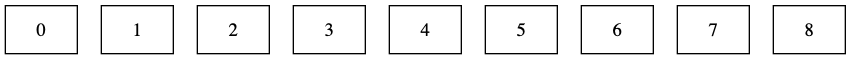

In [45]:
uoreg_df.visualize()

## Exploring ambient temperature data

Plotting the ambient temperature data to get an overview of it, try to visually identify possible outliers and check the points highlighted from each quality control flag value

In [ ]:
data = [go.Scatter(x=uoreg_df.index.compute(), y=uoreg_df.ambient_temperature_1)]
layout = go.Layout(title='Ambient temperature 1')
fig = go.FigureWidget(data, layout)
fig

In [ ]:
uoreg_df.qlt_ctrl_flag_1.unique().compute()

In [ ]:
len(uoreg_df)

In [ ]:
uoreg_df_raw = uoreg_df[uoreg_df.qlt_ctrl_flag_1 == 11]
uoreg_df_bad = uoreg_df[uoreg_df.qlt_ctrl_flag_1 == 99]

In [ ]:
len(uoreg_df_raw) + len(uoreg_df_bad)

In [ ]:
len(uoreg_df_raw)

In [ ]:
len(uoreg_df_bad)

In [ ]:
uoreg_df_raw.head()

In [ ]:
uoreg_df_bad.head()

In [ ]:
# data = [go.Scatter(x = uoreg_df_raw.index.compute(), y = uoreg_df_raw.ambient_temperature_1,
#                    name='raw data',
#                    marker=dict(color='blue')),
#         go.Scatter(x = uoreg_df_bad.index.compute(), y = uoreg_df_bad.ambient_temperature_1,
#                    name='bad data',
#                    marker=dict(color='red'))]
# layout = go.Layout(title='Ambient temperature 1')
# fig = go.Figure(data, layout)
# py.iplot(fig)

The above plot is straightforward and adds a legend indicating what each color means. However, as raw and bad data points are treated as separate data, the lines formed in the plot are misleading and unintuitive. It's better to go through a different approach, if we want to keep the lines, or just to use the markers, as done in the next cell:

In [ ]:
data = [go.Scatter(x=uoreg_df_raw.index.compute(), y=uoreg_df_raw.ambient_temperature_1.compute(),
                   name='raw data',
                   marker=dict(color='blue')),
        go.Scatter(x=uoreg_df_bad.index.compute(), y=uoreg_df_bad.ambient_temperature_1.compute(),
                   name='bad data',
                   marker=dict(color='red'))]
layout = go.Layout(title='Ambient temperature 1')
fig = go.FigureWidget(data, layout)
fig

In [ ]:
# colors = [1 if val == 99 else 0 for val in uoreg_df.qlt_ctrl_flag_1.compute()]

In [ ]:
# colors

In [ ]:
# data = [go.Scatter(x = uoreg_df.index.compute(), y = uoreg_df.ambient_temperature_1,
#                    marker=dict(color=colors,
#                                colorscale=[[0, 'blue'], [1, 'red']],
#                                cmax=1,
#                                cmin=0))]
# layout = go.Layout(title='Ambient temperature 1')
# fig = go.Figure(data, layout)
# py.iplot(fig)

In [ ]:
# data = [go.Scatter(x = uoreg_df.index.compute(), y = uoreg_df.ambient_temperature_1,
#                    marker=dict(color=colors,
#                                colorscale=[[0, 'blue'], [1, 'red']],
#                                cmax=1,
#                                cmin=0),
#                    mode='markers')]
# layout = go.Layout(title='Ambient temperature 1')
# fig = go.Figure(data, layout)
# py.iplot(fig)

The previous cell shows not only that picking colors point by point requires not using lines, which removes any advantage over separating data in different traces/plots, it also seems to be slower.

## Testing the outlier detection algorithms

### Good ol' thresholds

Documentation: https://www.notion.so/andrecnf/Good-ol-thresholds-4a5786d7078a41d5806719e5ecc17068

#### Absolute value thresholds

In [ ]:
thresh_outliers = data_processing.threshold_outlier_detect(uoreg_df.ambient_temperature_1, max_thrs=35, min_thrs=-10)
thresh_outliers.head()

In [ ]:
thresh_outliers.value_counts().compute()

In [ ]:
data = [go.Scatter(x=uoreg_df.index.compute(), y=uoreg_df.ambient_temperature_1.compute(),
                   name='data',
                   marker=dict(color='blue')),
        go.Scatter(x=uoreg_df[thresh_outliers].index.compute(), y=uoreg_df[thresh_outliers].ambient_temperature_1.compute(),
                   name='outliers',
                   mode='markers',
                   marker=dict(color='red'))]
layout = go.Layout(title='Ambient temperature 1 - With threshold outliers')
fig = go.FigureWidget(data, layout)
fig

Everything seems to be working fine with absolute value threshold outlier detection!

#### Mean value thresholds

In [ ]:
thresh_outliers = data_processing.threshold_outlier_detect(uoreg_df.ambient_temperature_1, max_thrs=4, min_thrs=0.25, threshold_type='mean')
thresh_outliers.head()

In [ ]:
thresh_outliers.value_counts().compute()

In [ ]:
uoreg_df.ambient_temperature_1.mean().compute()

In [ ]:
data = [go.Scatter(x=uoreg_df.index.compute(), y=uoreg_df.ambient_temperature_1.compute(),
                   name='data',
                   marker=dict(color='blue')),
        go.Scatter(x=uoreg_df[thresh_outliers].index.compute(), y=uoreg_df[thresh_outliers].ambient_temperature_1.compute(),
                   name='outliers',
                   mode='markers',
                   marker=dict(color='red'))]
layout = go.Layout(title='Ambient temperature 1 - With threshold outliers')
fig = go.FigureWidget(data, layout)
fig

Everything seems to be working fine with mean value threshold outlier detection!

#### Median value thresholds

In [ ]:
thresh_outliers = data_processing.threshold_outlier_detect(uoreg_df.ambient_temperature_1, max_thrs=4, min_thrs=0.25, threshold_type='median')
thresh_outliers.head()

In [ ]:
thresh_outliers.value_counts().compute()

In [ ]:
uoreg_df.ambient_temperature_1.compute().median()

In [ ]:
data = [go.Scatter(x=uoreg_df.index.compute(), y=uoreg_df.ambient_temperature_1.compute(),
                   name='data',
                   marker=dict(color='blue')),
        go.Scatter(x=uoreg_df[thresh_outliers].index.compute(), y=uoreg_df[thresh_outliers].ambient_temperature_1.compute(),
                   name='outliers',
                   mode='markers',
                   marker=dict(color='red'))]
layout = go.Layout(title='Ambient temperature 1 - With threshold outliers')
fig = go.FigureWidget(data, layout)
fig

Everything seems to be working fine with median value threshold outlier detection!

#### Standard deviation value thresholds

In [ ]:
thresh_outliers = data_processing.threshold_outlier_detect(uoreg_df.ambient_temperature_1, max_thrs=1.5, min_thrs=-1.5, threshold_type='std')
thresh_outliers.head()

In [ ]:
thresh_outliers.value_counts().compute()

In [ ]:
data = [go.Scatter(x=uoreg_df.index.compute(), y=uoreg_df.ambient_temperature_1.compute(),
                   name='data',
                   marker=dict(color='blue')),
        go.Scatter(x=uoreg_df[thresh_outliers].index.compute(), y=uoreg_df[thresh_outliers].ambient_temperature_1.compute(),
                   name='outliers',
                   mode='markers',
                   marker=dict(color='red'))]
layout = go.Layout(title='Ambient temperature 1 - With threshold outliers')
fig = go.FigureWidget(data, layout)
fig

Let's visualize the normalized ambient temperature for comparison:

In [ ]:
norm_amb_tmp = (uoreg_df.ambient_temperature_1 - uoreg_df.ambient_temperature_1.mean()) / \
                uoreg_df.ambient_temperature_1.std()
norm_amb_tmp.head()

In [ ]:
data = [go.Scatter(x=norm_amb_tmp.index.compute(), y=norm_amb_tmp.compute(),
                   name='data',
                   marker=dict(color='blue')),
        go.Scatter(x=norm_amb_tmp[thresh_outliers].index.compute(), y=norm_amb_tmp[thresh_outliers].compute(),
                   name='outliers',
                   mode='markers',
                   marker=dict(color='red'))]
layout = go.Layout(title='Ambient temperature 1 - With threshold outliers')
fig = go.FigureWidget(data, layout)
fig

Everything seems to be working fine with standard deviation value threshold outlier detection!

#### Absolute derivative thresholds

In [ ]:
thresh_outliers = data_processing.threshold_outlier_detect(uoreg_df.ambient_temperature_1, max_thrs=4, min_thrs=-4, signal_type='derivative', time_scale='minutes')
thresh_outliers.head()

In [ ]:
thresh_outliers.value_counts().compute()

In [ ]:
data = [go.Scatter(x=uoreg_df.index.compute(), y=uoreg_df.ambient_temperature_1.compute(),
                   name='data',
                   marker=dict(color='blue')),
        go.Scatter(x=uoreg_df[thresh_outliers].index.compute(), y=uoreg_df[thresh_outliers].ambient_temperature_1.compute(),
                   name='outliers',
                   mode='markers',
                   marker=dict(color='red'))]
layout = go.Layout(title='Ambient temperature 1 - With threshold outliers')
fig = go.FigureWidget(data, layout)
fig

Let's plot the derivative for comparison:

In [ ]:
drvt_amb_tmp = uoreg_df.ambient_temperature_1.diff()
drvt_amb_tmp = drvt_amb_tmp / data_processing.signal_idx_derivative(drvt_amb_tmp, time_scale='minutes')
drvt_amb_tmp.head()

In [ ]:
data = [go.Scatter(x=drvt_amb_tmp.index.compute(), y=drvt_amb_tmp.compute(),
                   name='data',
                   marker=dict(color='blue')),
        go.Scatter(x=drvt_amb_tmp[thresh_outliers].index.compute(), y=drvt_amb_tmp[thresh_outliers].compute(),
                   name='outliers',
                   mode='markers',
                   marker=dict(color='red'))]
layout = go.Layout(title='Ambient temperature 1 - With threshold outliers')
fig = go.FigureWidget(data, layout)
fig

Everything seems to be working fine with absolute derivative threshold outlier detection!

### Jungle slopes

Documentation: https://www.notion.so/andrecnf/Jungle-slopes-e9907da9a5bb415e8698e55d9a85407f

In [ ]:
slopes_outliers = data_processing.slopes_outlier_detect(uoreg_df.ambient_temperature_1, time_scale='minutes')
slopes_outliers.head()

In [ ]:
slopes_outliers.value_counts().compute()

In [ ]:
data = [go.Scatter(x=uoreg_df.index.compute(), y=uoreg_df.ambient_temperature_1.compute(),
                   name='data',
                   marker=dict(color='blue')),
        go.Scatter(x=uoreg_df[slopes_outliers].index.compute(), y=uoreg_df[slopes_outliers].ambient_temperature_1.compute(),
                   name='outliers',
                   mode='markers',
                   marker=dict(color='red'))]
layout = go.Layout(title='Ambient temperature 1 - With threshold outliers')
fig = go.FigureWidget(data, layout)
fig

Experiment only considering as outliers the data points that have large derivatives on both directions:

In [49]:
slopes_outliers = data_processing.slopes_outlier_detect(uoreg_df.ambient_temperature_1, time_scale='minutes', only_bir=True)
slopes_outliers.head()

ts
2019-01-01 00:00:00    False
2019-01-01 00:01:00    False
2019-01-01 00:02:00    False
2019-01-01 00:03:00    False
2019-01-01 00:04:00    False
dtype: bool

In [50]:
slopes_outliers.value_counts().compute()

False    392904
True        216
dtype: int64

In [51]:
data = [go.Scatter(x=uoreg_df.index.compute(), y=uoreg_df.ambient_temperature_1.compute(),
                   name='data',
                   marker=dict(color='blue')),
        go.Scatter(x=uoreg_df[slopes_outliers].index.compute(), y=uoreg_df[slopes_outliers].ambient_temperature_1.compute(),
                   name='outliers',
                   mode='markers',
                   marker=dict(color='red'))]
layout = go.Layout(title='Ambient temperature 1 - With threshold outliers')
fig = go.FigureWidget(data, layout)
fig

FigureWidget({
    'data': [{'marker': {'color': 'blue'},
              'name': 'data',
              'type': …

Everything seems to be working fine with absolute value threshold outlier detection!

### Rolling MAD

Documentation: https://www.notion.so/andrecnf/Rolling-MAD-5e37b70dab8d4030846c3a4d4ca78afb